#Project 8: Xây dựng bộ lọc ảnh


### Kết nối Google Drive

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
cd /content/drive/'My Drive'/20202-Image-Process/img

/content/drive/My Drive/20202-Image-Process/img


### Các thư viện cần sử dụng

In [96]:
import numpy as np
from scipy import signal
import cv2
from matplotlib import pyplot as plt
%matplotlib inline


### Xây dựng phép tích chập (Convolution) và Phép tương quan chéo (Cross-Correlation)
Phép tích chập dùng trong các bộ lọc tuyến tính

In [97]:
def convolute(image, kernel):
  # Lật ma trận mặt nạ
  r,c = kernel.shape
  flipped_kernel = np.zeros((r,c),np.float32)
  h=0
  if r==c and r%2 :
    h = int((r-1)/2)
    for i in range(-h,h+1):
     for j in range(-h,h+1):
      flipped_kernel[i+h,j+h]=kernel[-i+h,-j+h]
  # Thêm padding cho ảnh đầu vào
  m,n = image.shape
  padded_image = np.zeros((m+2*h,n+2*h),np.float32)
  padded_image[h:-h,h:-h] = image
  # Tạo ảnh đầu ra
  output = np.zeros((m,n),np.float32)
  for i in range(m):
   for j in range(n):
    output[i,j]=(flipped_kernel * padded_image[i: i+r, j: j+r]).sum()
  return output

In [98]:
def cross_correlate(image, kernel):
  r,c = kernel.shape
  h=0
  if r==c and r%2 :
    h = int((r-1)/2)
  # Thêm padding cho ảnh đầu vào
  m,n = image.shape
  padded_image = np.zeros((m+2*h,n+2*h),int)
  padded_image[h:-h,h:-h] = image
  # Tạo ảnh đầu ra
  output = np.zeros((m,n),np.float32)
  for i in range(m):
   for j in range(n):
    output[i,j]=(kernel * padded_image[i: i+r, j: j+r]).sum()
  return output

In [131]:
#Test hàm tích chập và tương quan bằng ma trận cỡ nhỏ
input1 = np.array([[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]])
kernel1 = np.array([[1,0,-1],[2,1,-2],[1,0,-1]])
output1 = convolute(input1, kernel1)
print('Ket qua ham convolute tu tao:\n',output1)
con=signal.convolve2d(input1, kernel1, mode='same', boundary='fill', fillvalue=0)
print('Ket qua ham convolve2d co san:\n',con)
output2 = cross_correlate(input1, kernel1)
print('Ket qua ham cross_correlate tu tao:\n',output2)
corr=signal.correlate2d(input1, kernel1, mode='same', boundary='fill', fillvalue=0)
print('Ket qua ham correlate2d co san:\n',corr)
corr2=cv2.filter2D(input1.astype(np.float32),-1,kernel1,borderType=cv2.BORDER_ISOLATED)
print('Ket qua ham filter2d co san:\n',corr2)

Ket qua ham convolute tu tao:
 [[ 12.   8.   9.  10. -12.]
 [ 34.  15.  16.  17. -26.]
 [ 42.  18.  19.  20. -22.]]
Ket qua ham convolve2d co san:
 [[ 12   8   9  10 -12]
 [ 34  15  16  17 -26]
 [ 42  18  19  20 -22]]
Ket qua ham cross_correlate tu tao:
 [[-10.  -4.  -3.  -2.  22.]
 [-22.  -1.   0.   1.  46.]
 [-20.   6.   7.   8.  52.]]
Ket qua ham correlate2d co san:
 [[-10  -4  -3  -2  22]
 [-22  -1   0   1  46]
 [-20   6   7   8  52]]
Ket qua ham filter2d co san:
 [[-10.  -4.  -3.  -2.  22.]
 [-22.  -1.   0.   1.  46.]
 [-20.   6.   7.   8.  52.]]


### Bộ lọc trung bình (Mean Filter)
Là phép lọc tuyến tính, làm mịn, làm mờ hình ảnh, lọc nhiễu

In [100]:
# Xây dựng bộ lọc trung bình
def meanFilter(image,kernel_size,convol=1):
  #Tạo kernel
  kernel = np.ones((kernel_size,kernel_size),np.float32)/(kernel_size*kernel_size)
  #Tích chập hoặc tương quan
  if convol == 1:
    output = convolute(image,kernel)
  else:
    output = cv2.filter2D(image,-1,kernel,borderType=cv2.BORDER_ISOLATED)
  return output
  

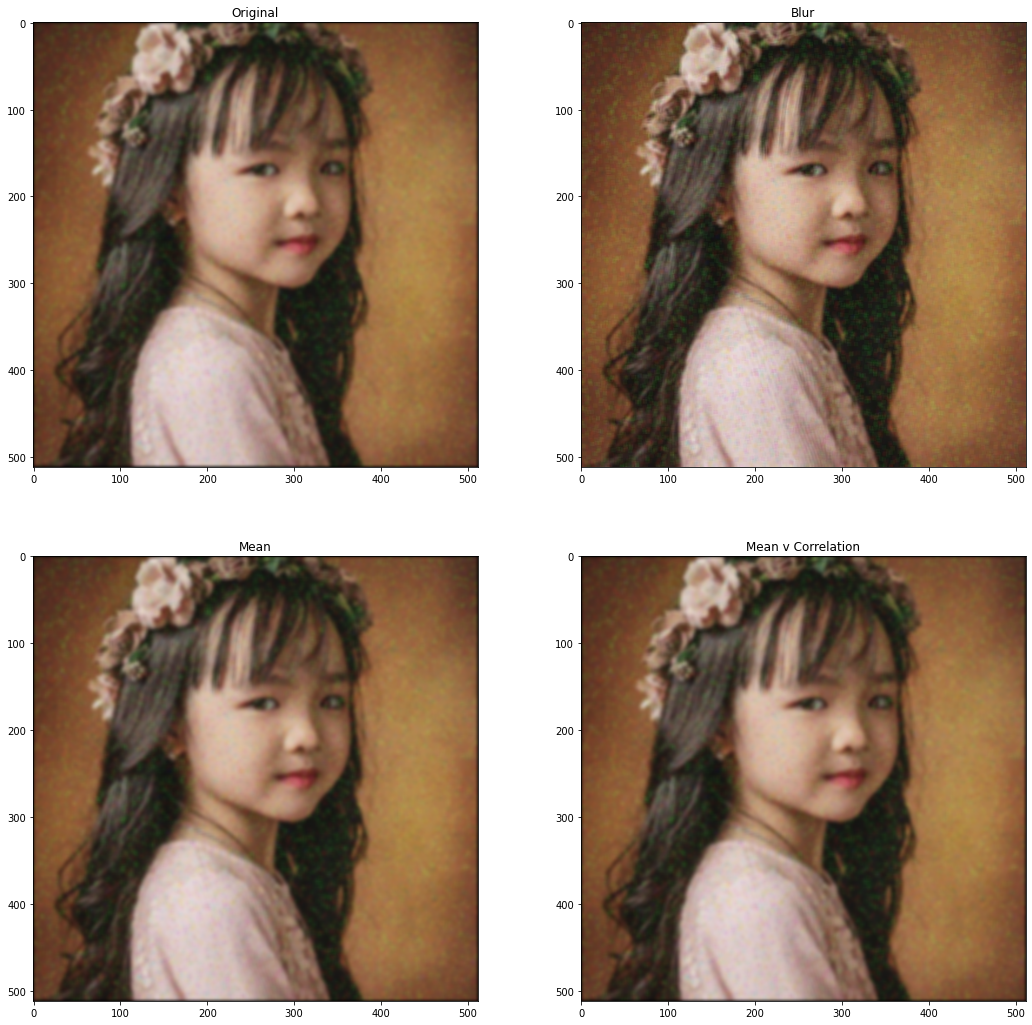

In [101]:
# Test bộ lọc trung bình
img = cv2.imread('girl1.jpg')
blur = cv2.blur(img, (5,5))
mean = mean_corr =img
for i in range(3):
    mean[:,:,i] = meanFilter(img[:,:,i],5)
    mean_corr[:,:,i] = meanFilter(img[:,:,i],5,0)

cv2.imwrite('blur.jpg', blur)
cv2.imwrite('mean.jpg', mean)
cv2.imwrite('mean_corr.jpg', mean)

plt.figure(figsize=(18,18))
plt.subplot(221), plt.title('Original'), plt.imshow(img[:,:,::-1])
plt.subplot(222), plt.title('Blur'), plt.imshow(blur[:,:,::-1])
plt.subplot(223), plt.title('Mean'), plt.imshow(mean[:,:,::-1])
plt.subplot(224), plt.title('Mean v Correlation'), plt.imshow(mean[:,:,::-1])
plt.show()

### Bộ lọc Gaussian

In [102]:
# Xây dựng bộ lọc Gaussian
def createGaussianKernel(kernel_size,sigma):
  h=kernel_size//2
  var = np.square(sigma)
  kernel=np.zeros((kernel_size,kernel_size),np.float)
  for i in range(kernel_size):
    for j in range(kernel_size):
      kernel[i,j] = np.exp(-(np.square(i-h)+np.square(j-h))/2/var)
  kernel = kernel/kernel.sum()
  return kernel
def GaussianFilter(image,kernel_size,sigma,convol=1):
  #Tạo kernel
  kernel = createGaussianKernel(kernel_size,sigma)
    #Tích chập hoặc tương quan
  if convol == 1:
    output = convolute(image,kernel)
  else:
    output = cv2.filter2D(image,-1,kernel,borderType=cv2.BORDER_ISOLATED)
  return output

Kernel được tạo ra: 
 [[0.00212141 0.01118005 0.01945585 0.01118005 0.00212141]
 [0.01118005 0.05892002 0.10253432 0.05892002 0.01118005]
 [0.01945585 0.10253432 0.17843318 0.10253432 0.01945585]
 [0.01118005 0.05892002 0.10253432 0.05892002 0.01118005]
 [0.00212141 0.01118005 0.01945585 0.01118005 0.00212141]]


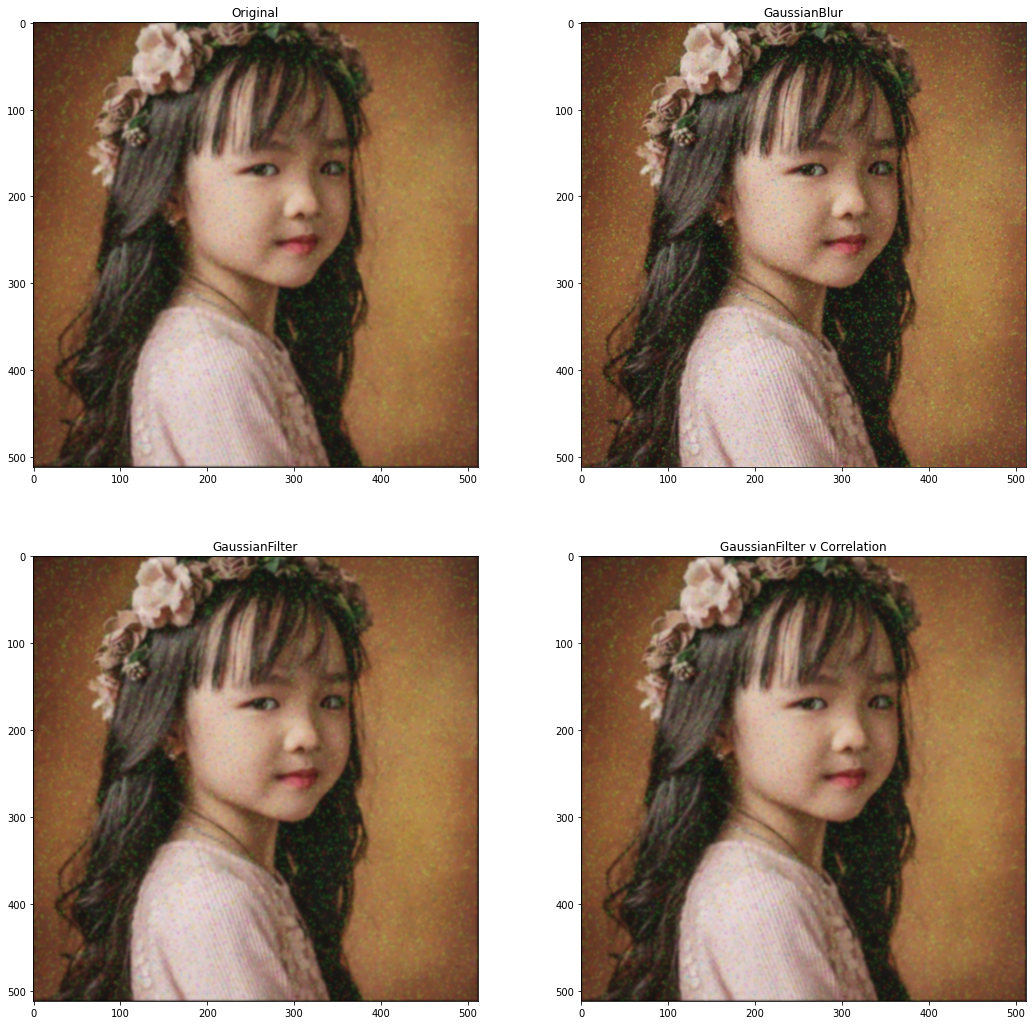

In [132]:
# Test bộ lọc Gaussian
img = cv2.imread('girl1.jpg')
GaussBlur = cv2.GaussianBlur(img, (5,5),0.95)
GaussianFilt = GaussianFilt_corr = img
for i in range(3):
    GaussianFilt[:,:,i] = GaussianFilter(img[:,:,i],5,0.95)
    GaussianFilt_corr[:,:,i] = GaussianFilter(img[:,:,i],5,0.95,0)

cv2.imwrite('GaussianBlur.jpg',GaussBlur)
cv2.imwrite('GaussianFilter.jpg', GaussianFilt)
cv2.imwrite('GaussianFilter_corr.jpg', GaussianFilt_corr)

print('Kernel được tạo ra: \n',createGaussianKernel(5,0.95))
plt.figure(figsize=(18,18))
plt.subplot(221), plt.title('Original'), plt.imshow(img[:,:,::-1])
plt.subplot(222), plt.title('GaussianBlur'), plt.imshow(GaussBlur[:,:,::-1])
plt.subplot(223), plt.title('GaussianFilter'), plt.imshow(GaussianFilt[:,:,::-1])
plt.subplot(224), plt.title('GaussianFilter v Correlation'), plt.imshow(GaussianFilt_corr[:,:,::-1])
plt.show()

### Bộ lọc trung vị (Median Filter)
Là phép lọc phi tuyến, hiệu quả với lọc nhiễu đốm, nhiễu muối tiêu



In [104]:
# Xây dựng bộ lọc trung vị
def medianFilter(image, kernel_size):
 h=kernel_size//2
 m,n = image.shape
 # Thêm padding cho ảnh đầu vào
 padded_image = np.zeros((m+2*h,n+2*h),int)
 padded_image[h:-h,h:-h] = image
 padded_image[:h,h:-h] = image[:h,:]
 padded_image[-h:,h:-h] = image[-h:,:]
 padded_image[h:-h,:h] = image[:,:h]
 padded_image[h:-h,-h:] = image[:,-h:]
 Kernel_len = kernel_size*kernel_size
 # Tạo ma trận đầu ra
 output = np.zeros((m,n),int)
 for i in range(m):
   for j in range(n):
     array = np.zeros(Kernel_len,int)
     for p in range(kernel_size):
       for q in range(kernel_size):
         array[p*kernel_size+q]=padded_image[i+p,j+q]
     array = np.sort(array)
     output[i,j]=array[len(array)//2]
 return output

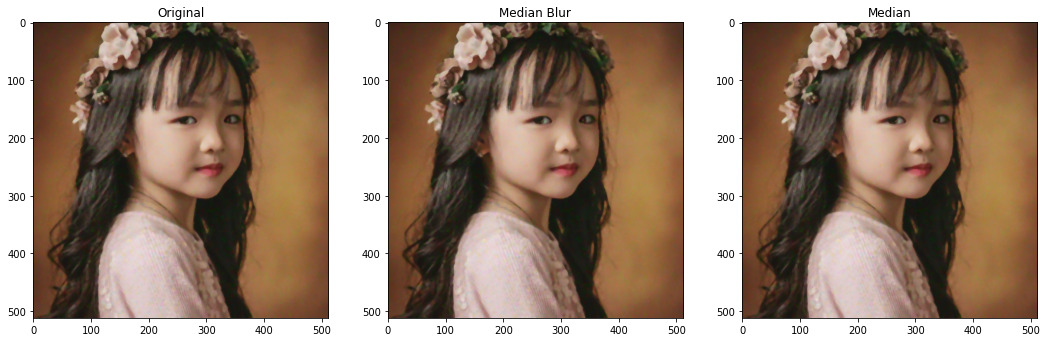

In [105]:
# Test bộ lọc trung vị
img = cv2.imread('girl1.jpg')
medianBlur = cv2.medianBlur(img, 5)
medianFilt = img
for i in range(3):
 medianFilt[:,:,i]=medianFilter(img[:,:,i],5)

cv2.imwrite('medianBlur.jpg',medianBlur)
cv2.imwrite('medianFilter.jpg',medianFilt)
plt.figure(figsize=(18,18))
plt.subplot(131), plt.title('Original'), plt.imshow(img[:,:,::-1])
plt.subplot(132), plt.title('Median Blur'), plt.imshow(medianBlur[:,:,::-1])
plt.subplot(133), plt.title('Median'), plt.imshow(medianFilt[:,:,::-1])
plt.show()

### Bộ lọc Laplacian
Tìm biên ảnh

In [106]:
# Xây dựng bộ lọc Laplacian
def LaplaceFilter(image,kernel_type = 1,convol=1):
  #Tạo kernel
  if kernel_type==2:
    kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
  elif kernel_type==3:
    kernel = np.array([[1,-2,1],[-2,4,-2],[1,-2,1]])
  else:
    kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
  #Tích chập hoặc tương quan
  if convol == 1:
    output = convolute(image,kernel)
  else:
    output = cv2.filter2D(image,-1,kernel,borderType=cv2.BORDER_ISOLATED)
  return output

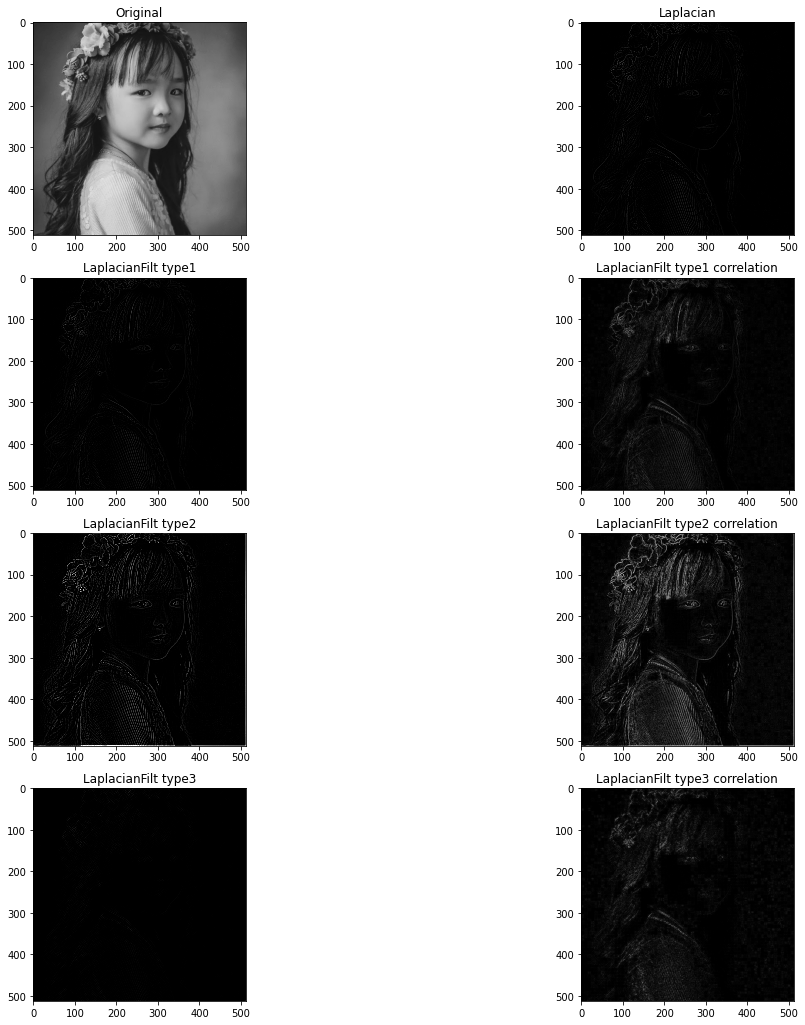

In [107]:
# Test bộ lọc Laplacian
img = cv2.imread('girl.jpg',cv2.IMREAD_GRAYSCALE)
Laplacian = cv2.Laplacian(img,cv2.CV_64F)
LaplacianFilt1 = LaplaceFilter(img)
LaplacianFilt2 = LaplaceFilter(img,2)
LaplacianFilt3 = LaplaceFilter(img,3)
LaplacianFilt1_corr = LaplaceFilter(img,1,0)
LaplacianFilt2_corr = LaplaceFilter(img,2,0)
LaplacianFilt3_corr = LaplaceFilter(img,3,0)

cv2.imwrite('girl_gray.jpg', img)
cv2.imwrite('Laplacian.jpg', Laplacian)
cv2.imwrite('Laplacian1.jpg',LaplacianFilt1)
cv2.imwrite('Laplacian2.jpg', LaplacianFilt2)
cv2.imwrite('Laplacian3.jpg', LaplacianFilt3)
cv2.imwrite('Laplacian1_corr.jpg',LaplacianFilt1_corr)
cv2.imwrite('Laplacian2_corr.jpg', LaplacianFilt2_corr)
cv2.imwrite('Laplacian3_corr.jpg', LaplacianFilt3_corr)

plt.figure(figsize=(18,18))
plt.subplot(421), plt.title('Original'), plt.imshow(img,cmap='gray',vmin=0,vmax=255)
plt.subplot(422), plt.title('Laplacian'), plt.imshow(Laplacian,cmap='gray',vmin=0,vmax=255)
plt.subplot(423), plt.title('LaplacianFilt type1'), plt.imshow(LaplacianFilt1,cmap='gray',vmin=0,vmax=255)
plt.subplot(425), plt.title('LaplacianFilt type2'), plt.imshow(LaplacianFilt2,cmap='gray',vmin=0,vmax=255)
plt.subplot(427), plt.title('LaplacianFilt type3'), plt.imshow(LaplacianFilt3,cmap='gray',vmin=0,vmax=255)
plt.subplot(424), plt.title('LaplacianFilt type1 correlation'), plt.imshow(LaplacianFilt1_corr,cmap='gray',vmin=0,vmax=255)
plt.subplot(426), plt.title('LaplacianFilt type2 correlation'), plt.imshow(LaplacianFilt2_corr,cmap='gray',vmin=0,vmax=255)
plt.subplot(428), plt.title('LaplacianFilt type3 correlation'), plt.imshow(LaplacianFilt3_corr,cmap='gray',vmin=0,vmax=255)
plt.show()

### Bộ lọc Sobel

In [127]:
def SobelFilter(image,gauss_ksize=5,dx=1,dy=1,convol=1,threshold=60):
  GaussKernel = createGaussianKernel(gauss_ksize,1)
  X = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
  Y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    #Tích chập hoặc tương quan
  if convol == 1:
      kernel_x = convolute(GaussKernel,X)
      sobel_x = convolute(image,kernel_x)
      kernel_y = convolute(GaussKernel,Y)
      sobel_y = convolute(image,kernel_y)
  else:
      kernel_x = cv2.filter2D(GaussKernel,cv2.CV_64F,X,borderType=cv2.BORDER_ISOLATED)
      sobel_x = cv2.filter2D(image,cv2.CV_64F,kernel_x,borderType=cv2.BORDER_ISOLATED)
      kernel_y = cv2.filter2D(GaussKernel,cv2.CV_64F,Y,borderType=cv2.BORDER_ISOLATED)
      sobel_y = cv2.filter2D(image,cv2.CV_64F,kernel_y,borderType=cv2.BORDER_ISOLATED)

  if dx==1 and dy==0:
    return sobel_x
  if dx==0 and dy==1:
    return sobel_y
  sobel = np.sqrt(np.square(sobel_x)+np.square(sobel_y))
  img_sobel = np.uint8(sobel)
  for i in range(img_sobel.shape[0]):
      for j in range(img_sobel.shape[1]):
          if img_sobel[i][j] < threshold:
              img_sobel[i][j] = 0
  return img_sobel

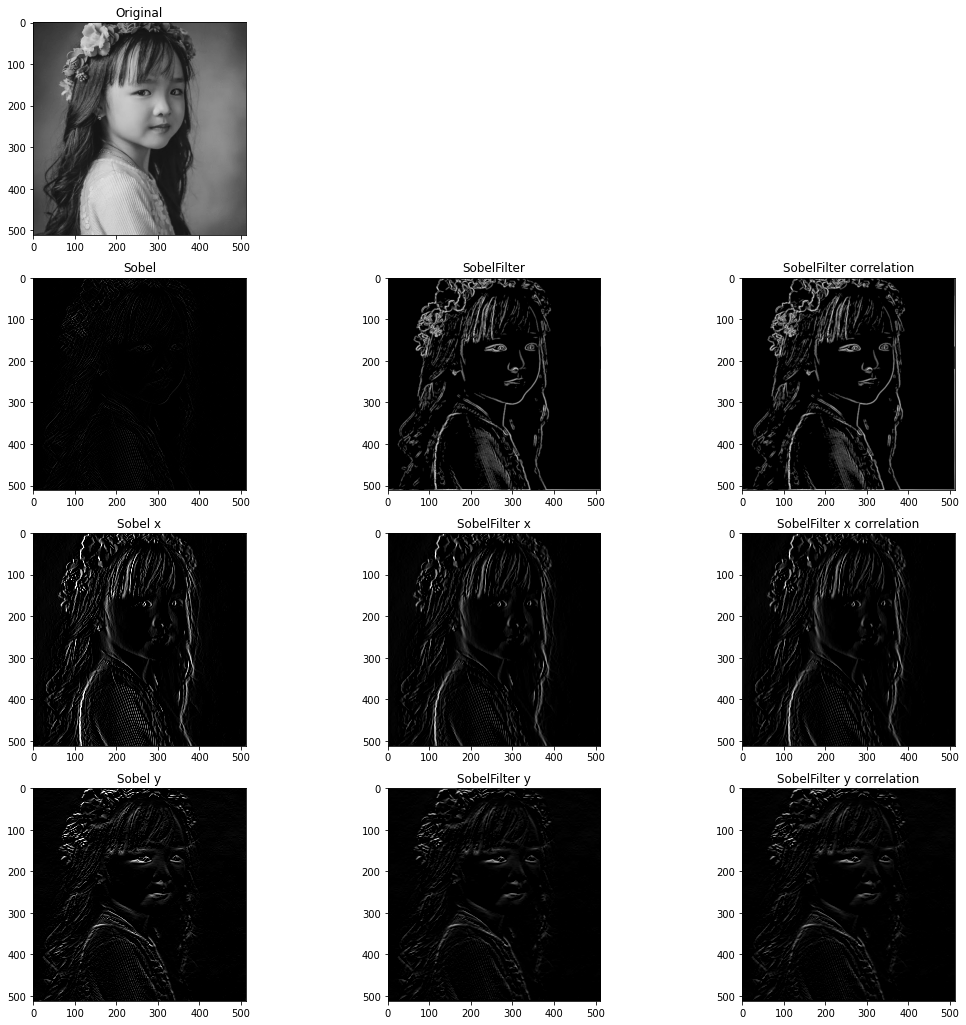

In [128]:
# Test bộ lọc Sobel
img = cv2.imread('girl.jpg',cv2.IMREAD_GRAYSCALE)
Sobelx = cv2.Sobel(img,cv2.CV_64F,1,0)
Sobely = cv2.Sobel(img,cv2.CV_64F,0,1)
Sobel = cv2.Sobel(img,cv2.CV_64F,1,1)
SobelFiltx = SobelFilter(img,5,1,0)
SobelFilty = SobelFilter(img,5,0,1)
SobelFilt = SobelFilter(img,5,1,1)
SobelFiltx_corr = SobelFilter(img,5,1,0,0)
SobelFilty_corr = SobelFilter(img,5,0,1,0)
SobelFilt_corr = SobelFilter(img,5,1,1,0)

cv2.imwrite('Sobelx.jpg', Sobelx)
cv2.imwrite('Sobely.jpg', Sobely)
cv2.imwrite('Sobel.jpg', Sobel)
cv2.imwrite('SobelFiltx.jpg',SobelFiltx)
cv2.imwrite('SobelFilty.jpg',SobelFilty)
cv2.imwrite('SobelFilt.jpg',SobelFilt)
cv2.imwrite('SobelFiltx_corr.jpg',SobelFiltx_corr)
cv2.imwrite('SobelFilty_corr.jpg',SobelFilty_corr)
cv2.imwrite('SobelFilt_corr.jpg',SobelFilt_corr)

plt.figure(figsize=(18,18))
plt.subplot(431), plt.title('Original'), plt.imshow(img,cmap='gray',vmin=0,vmax=255)
plt.subplot(434), plt.title('Sobel'), plt.imshow(Sobel,cmap='gray',vmin=0,vmax=255)
plt.subplot(435), plt.title('SobelFilter'), plt.imshow(SobelFilt,cmap='gray',vmin=0,vmax=255)
plt.subplot(436), plt.title('SobelFilter correlation'), plt.imshow(SobelFilt_corr,cmap='gray',vmin=0,vmax=255)
plt.subplot(437), plt.title('Sobel x'), plt.imshow(Sobelx,cmap='gray',vmin=0,vmax=255)
plt.subplot(438), plt.title('SobelFilter x'), plt.imshow(SobelFiltx,cmap='gray',vmin=0,vmax=255)
plt.subplot(439), plt.title('SobelFilter x correlation'), plt.imshow(SobelFiltx_corr,cmap='gray',vmin=0,vmax=255)
plt.subplot(4,3,10), plt.title('Sobel y'), plt.imshow(Sobely,cmap='gray',vmin=0,vmax=255)
plt.subplot(4,3,11), plt.title('SobelFilter y'), plt.imshow(SobelFilty,cmap='gray',vmin=0,vmax=255)
plt.subplot(4,3,12), plt.title('SobelFilter y correlation'), plt.imshow(SobelFilty_corr,cmap='gray',vmin=0,vmax=255)
plt.show()